In [ ]:
'''
확인한 관련자료!
https://joungheekim.github.io/2020/11/14/code-review/
https://dl.acm.org/doi/10.1145/3416013.3426457
http://web.stanford.edu/class/cs259d/
https://arxiv.org/pdf/2007.02500.pdf
https://arxiv.org/pdf/2106.07178.pdf
http://snap.stanford.edu/class/cs224w-2015/projects_2015/Anomaly_Detection_in_Graphs.pdf
https://www.hs-coburg.de/forschung/forschungsprojekte-oeffentlich/informationstechnologie/cidds-coburg-intrusion-detection-data-sets.html
CIDDS data sets
Public IP addresses are anonymized (see technical reports). The non-anonymised versions of the data sets cannot be publicly shared. Access on non-anonymised data sets can only be allowed on site at the University of Coburg upon request.

CIDDS-001 data set.zip (380MB)
Paper: Flow-based benchmark data sets for intrusion detection
Technical Report: Technical report CIDDS-001
CIDDS-002 data set.zip (200MB)
Paper: Creation of Flow Based
Technical Report: Technical report CIDDS-002
'''

'\nhttps://joungheekim.github.io/2020/11/14/code-review/\nhttps://dl.acm.org/doi/10.1145/3416013.3426457\nhttp://web.stanford.edu/class/cs259d/\nhttps://arxiv.org/pdf/2007.02500.pdf\nhttps://arxiv.org/pdf/2106.07178.pdf\nhttp://snap.stanford.edu/class/cs224w-2015/projects_2015/Anomaly_Detection_in_Graphs.pdf\nhttps://www.hs-coburg.de/forschung/forschungsprojekte-oeffentlich/informationstechnologie/cidds-coburg-intrusion-detection-data-sets.html\nCIDDS data sets\nPublic IP addresses are anonymized (see technical reports). The non-anonymised versions of the data sets cannot be publicly shared. Access on non-anonymised data sets can only be allowed on site at the University of Coburg upon request.\n\nCIDDS-001 data set.zip (380MB)\nPaper: Flow-based benchmark data sets for intrusion detection\nTechnical Report: Technical report CIDDS-001\nCIDDS-002 data set.zip (200MB)\nPaper: Creation of Flow Based\nTechnical Report: Technical report CIDDS-002\n\nhttps://cs230.stanford.edu/projects_sprin

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pk_df = pd.read_csv('/content/drive/MyDrive/hmPark/2021년 11월/04_hashed.csv')
pk_df['Rdate'] = pd.to_datetime(pk_df.Rdate)
pk_df = pk_df.dropna(subset=["dst_country"])

In [ ]:
pk1_df = pk_df[(pk_df['Action'] == 1)]  #### Allow 만
pk2_df = pk_df[(pk_df['Action'] == 2)]  #### Deny 만
pk0_df = pk_df[(pk_df['Action'] == 0)]  #### 둘다 아닌것

In [ ]:
#### ip 를 bin ( 혹은 decimal ) 로 encoding 하는 논문입니다.
#### https://hammer.purdue.edu/articles/thesis/Encoding_IP_Address_as_a_Feature_for_Network_Intrusion_Detection/11307287

import ipaddress
pk_df['dst_ip'] = pk_df['dst_ip'].apply(ipaddress.IPv4Address).astype(int)
pk_df['src_ip'] = pk_df['src_ip'].apply(ipaddress.IPv4Address).astype(int)

In [ ]:
pk_df.isnull().sum()

Rdate          0
src_ip         0
dst_ip         0
Proto          0
src_port       0
dst_port       0
Action         0
src_country    0
dst_country    0
dtype: int64

In [ ]:
#### "src_ip", "dst_ip", "Proto", "src_port", "dst_port", "Action" 의 column feature 만 가지고 
#### Action field 를 clustering 하려고 하는 k 값으로 사용해 보자
pk_df_clustering = pk_df[["src_ip", "dst_ip", "Proto", "src_port", "dst_port", "Action"]]
pk_df_clustering.columns = ["src_ip", "dst_ip", "Proto", "src_port", "dst_port", "cluster"]

In [ ]:
pk_df_clustering.head()

,src_ip,dst_ip,Proto,src_port,dst_port,cluster
0,2587533158,1739656234,6,52897,445,2
1,2587533076,2101501124,6,60579,445,2
2,2587533220,1970909919,6,63831,445,2
3,2587533221,3441581921,6,55241,445,2
4,2587533158,1563993219,6,52898,445,2


클러스터링에 사용할 변수들의 크기 범위가 많이 다르다면

특정 변수의 크기에 강한 영향을 받지 않도록 

전체적으로 값을  StandardScaler를 사용하여 스케일링 해서 같은 범위로 줄일 수 있다. 

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
pk_df_clustering_sc = sc.fit_transform(pk_df_clustering)

In [ ]:
pk_df_clustering_sc

array([[-0.02171273, -0.41764892, -0.85376941,  0.20662317, -0.18398895,
         0.88178221],
       [-0.0217128 , -0.06381771, -0.85376941,  0.79506484, -0.18398895,
         0.88178221],
       [-0.02171268, -0.19151675, -0.85376941,  1.04416824, -0.18398895,
         0.88178221],
       ...,
       [-0.13349449, -0.9252124 , -0.85376941, -1.8808051 , -0.23921745,
         0.88178221],
       [-0.02171268,  0.92599547, -0.85376941,  0.33960088, -0.18398895,
         0.88178221],
       [-0.0217128 ,  0.84263253, -0.85376941,  0.26384342, -0.18398895,
         0.88178221]])

#클러스터링 시각화

클러스터링에 사용한 변수는 5개 "src_ip", "dst_ip", "Proto", "src_port", "dst_port" 입니다.

우리가 시각화를 한다는 것은 일반적으로 x축과 y축에 값이 존재하여
2차원의 데이터로 표현한다는 것을 의미하는데 2차원이라는 것은 숫자가 2개밖에 없다는 거죠.

그래서 숫자가 두 개밖에 없으니 둘 중 하나는 x축의 값, 둘 중 하나는 y축의 값으로 하면
시각화가 가능합니다.

그런데 현재 우리가 클러스터링을 진행한 변수의 개수는 5개에요.
우리가 5차원 데이터. 즉, 5개의 숫자를 가지고 시각화를 할 수는 없어요.

그래서 5차원 데이터를 2차원 데이터로 줄이면 시각화가 가능할텐데요.
이럴 때 사용하는 것을 차원 축소라고 해요.

차원 축소란 클러스터링과 마찬가지로 레이블이 없이 학습하는
비지도 학습의 머신 러닝 방식의 일종으로 정보를 되도록 잃지 않도록 하게 하면서 차원은 줄이는 방법이에요.
학습 후에는 5개의 변수가 2개의 변수로 표현이 가능하게 되고,
2차원이 되면 각 값을 x축의 값, y축의 값으로 사용하면 되니까 시각화를 할 수가 있게 되는 것이죠.

여기서 차원 축소의 대표적인 방법인 주성분 분석(PCA)를 사용합니다.

그리고 여기서는 Action column 을 cluster column 값으로 을 사용하도록 하겠습니다.

PCA 차원 축소 참고 자료(필수 시청 권장) : https://youtu.be/DUJ2vwjRQag

In [ ]:
from sklearn.decomposition import PCA

# n_components의 값은 몇 차원으로 줄일 것이냐에 대한 값.
# 시각화를 하고자 하신다면 2를 적어주시면 되겠지요.
pca = PCA(n_components=2)  #### 축소할 차원을 적어준다 

X = pk_df_clustering_sc
# 객체를 만드고 나신 후에는 fit_trainsform(변수가 여러 개인 여러분이 차원을 줄이고자 하는 데이터)
x_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(x_pca)

In [ ]:
pca_df

,0,1
0,-1.161627,-0.066819
1,-1.297510,-0.535843
2,-1.407884,-0.593428
3,-0.906675,-1.000529
4,-1.194370,0.020406
...,...,...
5817118,-2.182139,-0.280230
5817119,-1.977910,-0.825168
5817120,-0.574218,1.190784
5817121,-0.951648,-0.814772


In [ ]:
# 아래와 같이 kmeans.fit 을 하여 cluster column 값을 얻을 수 있다. 
# kmeans = KMeans(n_clusters=3, random_state=0)
# clusters = kmeans.fit(pk_df_clustering_sc)
# customer_clustering["cluster"] = clusters.labels_
# print(pk_df_clustering["cluster"].unique())
# 여기서는 해석의 용이상 Action 0,1,2 를 cluster column 으로 사용해 보기로 한다.

In [ ]:
pca_df["cluster"] = pk_df_clustering["cluster"]

In [ ]:
pca_df

,0,1,cluster
0,-1.161627,-0.066819,2.0
1,-1.297510,-0.535843,2.0
2,-1.407884,-0.593428,2.0
3,-0.906675,-1.000529,2.0
4,-1.194370,0.020406,2.0
...,...,...,...
5817118,-2.182139,-0.280230,1.0
5817119,-1.977910,-0.825168,1.0
5817120,-0.574218,1.190784,1.0
5817121,-0.951648,-0.814772,1.0


위 데이터를 이제 차원이 2개. 즉, 숫자가 2개 밖에 없기 때문에

각각을 x축의 값, y축의 값으로 사용하여 시각화가 가능합니다.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

pk_df_clustering["cluster"].unique()

array([2, 1, 0])

2
1
0


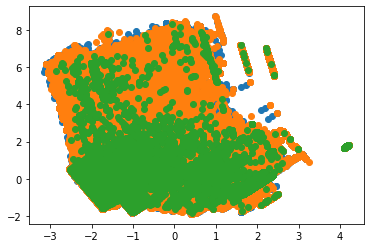

In [ ]:
for i in pk_df_clustering["cluster"].unique():
    print(i)
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])

In [ ]:
# cluster 2 : 3251557 entries : 녹색
# cluster 1 : 2543596 entries : 주황색
# cluster 0 : 25157 entries   : 파란색